# Introduction
It is my intention in this file to teach myself about count data models and the ins and outs of this type of regression modeling with some examples and discussions of what is what and what they mean. Fingers crossed! I will then try to apply what I learned to traffic crash data in order to develop safety performance functions per the guidelines in [HSM](https://www.highwaysafetymanual.org/Pages/default.aspx)

# Types of Models
Alright, so a little intro for myself on the various types of models on the data and why and how count models are different from the rest!
Obviously there area ton of modeling techniques, and what choice of model to use depends on the nature of the data and the research question you're dealing with. For example, 
1. Linear regression: To model the relationship between a **continuous dependent variable** and one or more independent variables.
2. Logistic regression: To model a **binary or categorical dependent variable** where the goal is to predict the probability of a certain outcome.
3. Poisson regression: To model **count data** where the goal is to predict the rate at which events occur.
4. Negative binomial regression, NB in short: To model **over-dispersed count data** where simple Poisson modeling technique is not reliable due to limitation in the modeling assumptions.
5. Time series analysis: To model **data that changes over time**, such as stock prices or weather patterns.
6. Survival analysis: To model the **time until an event occurs**, such as time until a patient dies or time until a machine fails.
7. Random forest: An ML technique to model **complex relationships between variables** usually where there are many independent variables.
8. Neural networks: Also an ML technique used to model **complex relationships between variables** similar to random forest for when there are many independent variables.

Why I am doing count modeling (i.e. will be doing # 3 and 4 and maybe others from above) is because that is my professional subject area with regards to traffic crash counts and how to predict them based on various types of categories which will come up later on.

So, I know that linear regression is not my modeling technique becasue <u>count data is discrete, non-negative, and often follows a skewed distribution</u>. <u>Linear regression models assume that the dependent variable is continuous and normally distributed</u>, which is not the case for count data. Using linear regression for count data violates the assumptions of the model, leading to biased and inefficient estimates, incorrect standard errors, and unreliable hypothesis tests. Furthermore, the predicted values can be negative, which is not possible for count data.

I also know that I can't use logistic regression for count data because that model assumes that the response variable follows a *Bernoulli distribution*, which is a discrete probability distribution that models the probability of a single event occurring in a single trial. But, count data often follows a Poisson or negative binomial distribution.

Nonetheless, let's pull in some count data and try various models and discuss results.

# Importing Libraries / Setting Options
I update this section every time I need to import a new library as I make progress. I just have an obsession to do all of the imports and options for how to show numbers, digits, outputs in one place rather than sporadically throughout my work.

In [ ]:
# Loading multiple libraries as needed in one line
lapply(c("tidyverse", "AER", "psych"), require, character.only = T)

# Have enough width for output so some are not shifted to next line!
options(width = 120)

In [29]:
# Specify number of significant decimal digits when printing output
options(digits = 3)

Here are several count data that can come handy, although I am not using all of them. Just writing them down for reference:
- Number of rooms data from the Boston dataset in `MASS` library
- Number of seizures for Epileptics from Epil datasets in `MASS` library
- Number of sattelite (unpaired) crabs from the Crabs dataset in `glmbb` library
- Number of claims from Insurance dataset in `countreg` library
- Number of affairs from Affairs dataset in `AER` library (AER for Applied Econometrics with R)
- Number of visits from DoctorVisits dataset in `AER` library
- Number of doctor visits from Medicaid1986 dataset in `AER` library
- Number of accidents from ShipAccidents dataset in `AER` library
- Number of derogetory reports from the CreditCard dataset in `AER` library
- Number of articles from PhDPublications dataset in `AER` library
- Number of kids from GSS7402 dataset in `AER` library
- Several count variables in NMES1988 dataset (medical care) `AER` library
- Several count variables in EquationCitations datasets in `AER` library
- A count dataset from this [Kaggle Page](https://www.kaggle.com/datasets/pablomonleon/montreal-bike-lanes) that contains information on the Number of bicycles that used certain bicycle lanes in Montreal in the year 2015. I removed a couple columns and changed some of the names for simplicity.
- A [roadway inventory dataset](https://geo-massdot.opendata.arcgis.com/datasets/MassDOT::road-inventory/about) from MassDOT's open data website. This data includes annual average daily tarffic (AADT) for various roads in MA along with other road properties for each segment. I made the data much lighter to handle by removing many rows some variables for the sake of my learning.

I am going to use the PhDPublications dataset to start my count modeling with.

In [3]:
bikes  <-  read.csv("MontrealBL.csv")
aadt  <- read.csv("RoadInventorysample.csv")
aadt <- aadt[complete.cases(aadt$AADT),]
data("PhDPublications")

First, let's look at the dataset, the variables and their types in the PhDPublications dataset. Then Let's take a quick look at some descriptive statistics about these variables and some visualization to know our data better as well.

In [11]:
print(head(PhDPublications, 3)) # I like using print but don't have to

  articles gender married kids prestige mentor
1        0   male     yes    0     2.52      7
2        0 female      no    0     2.05      6
3        0 female      no    0     3.75      6


There is the number `articles` (my count variable!). Then there are the binary variables of `gender` and `married`. There is another count variable `kids` which in this context is more like an explanatory variable than response. `prestige` is a continuous variable tha shows the prestige score of the program, and `mentor` is another nice count variable which shows the articles count published by the student's mentor.

In [12]:
glimpse(PhDPublications)

Rows: 915
Columns: 6
$ articles <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ gender   <fct> male, female, female, male, female, female, female, male, mal…
$ married  <fct> yes, no, no, yes, no, yes, no, yes, no, yes, no, no, yes, yes…
$ kids     <int> 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0…
$ prestige <dbl> 2.520, 2.050, 3.750, 1.180, 3.750, 3.590, 3.190, 2.960, 4.620…
$ mentor   <int> 7, 6, 6, 3, 26, 2, 3, 4, 6, 0, 14, 13, 3, 4, 0, 1, 7, 13, 7, …


In [31]:
summary(PhDPublications)

    articles        gender    married        kids          prestige        mentor    
 Min.   : 0.00   male  :494   no :309   Min.   :0.000   Min.   :0.75   Min.   : 0.0  
 1st Qu.: 0.00   female:421   yes:606   1st Qu.:0.000   1st Qu.:2.26   1st Qu.: 3.0  
 Median : 1.00                          Median :0.000   Median :3.15   Median : 6.0  
 Mean   : 1.69                          Mean   :0.495   Mean   :3.10   Mean   : 8.8  
 3rd Qu.: 2.00                          3rd Qu.:1.000   3rd Qu.:3.92   3rd Qu.:12.0  
 Max.   :19.00                          Max.   :3.000   Max.   :4.62   Max.   :77.0  

In [30]:
print(describe(PhDPublications))

         vars   n mean   sd median trimmed  mad  min   max range  skew kurtosis   se
articles    1 915 1.69 1.93   1.00    1.39 1.48 0.00 19.00 19.00  2.51    12.63 0.06
gender*     2 915 1.46 0.50   1.00    1.45 0.00 1.00  2.00  1.00  0.16    -1.98 0.02
married*    3 915 1.66 0.47   2.00    1.70 0.00 1.00  2.00  1.00 -0.69    -1.53 0.02
kids        4 915 0.50 0.76   0.00    0.35 0.00 0.00  3.00  3.00  1.37     0.89 0.03
prestige    5 915 3.10 0.98   3.15    3.13 1.32 0.75  4.62  3.86 -0.12    -1.08 0.03
mentor      6 915 8.77 9.48   6.00    7.10 5.93 0.00 77.00 77.00  2.42     8.37 0.31


In [38]:
cat("frequency table of the number of articles:")
table(PhDPublications$articles)

frequency table of the number of articles:


  0   1   2   3   4   5   6   7   8   9  10  11  12  16  19 
275 246 178  84  67  27  17  12   1   2   1   1   2   1   1 

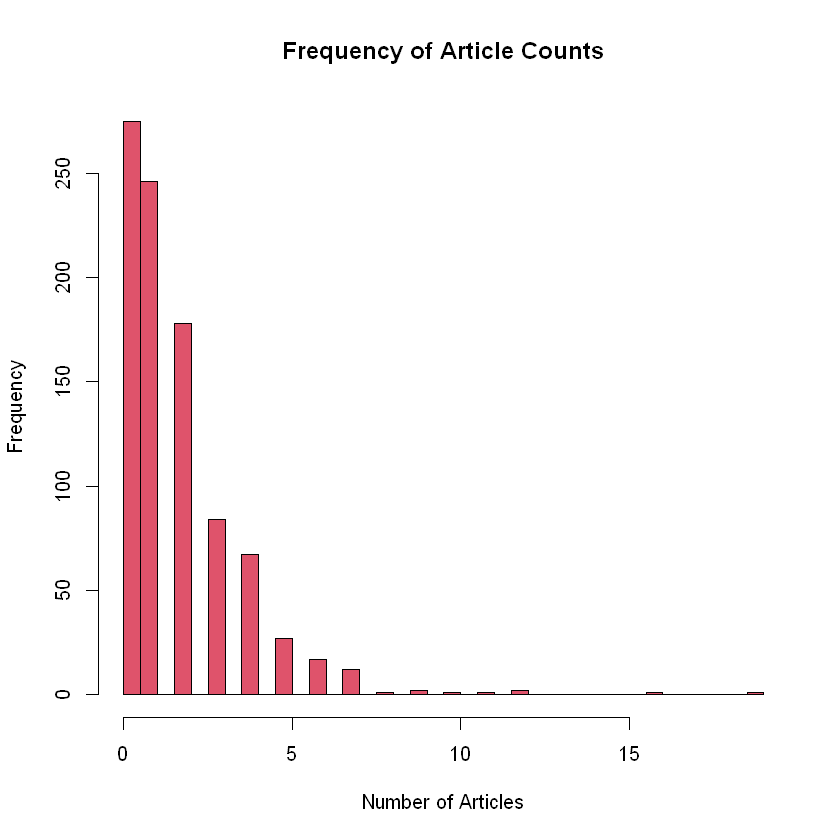

In [41]:
hist(PhDPublications$articles, 
     breaks = 30,
     main = "Frequency of Article Counts",
     col = 2,
     xlab = "Number of Articles")

- Number of articles published by students vary between 0-19 with an average of ~ 1.7 and intersetingly. With median of smaller than mean and so large a range, this is skewed to the right distribution and the skew and kutosis shows this too.
- Number of articles for the mentors vary between 0-77 with an average of ~ 8.8. 
- Number of kids was not so high with a max of 3

Let's see how things are once grouped for gender and/or married but this time visually.